<a href="https://colab.research.google.com/github/Shrey-Viradiya/PyTorch_for_DL/blob/master/PyTorch_Transfer_Learning_And_Other_Tricks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch_Transfer Learning And Other Tricks

In [1]:
!nvidia-smi

Fri Oct  2 08:02:26 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!unzip -n '/content/drive/My Drive/images.zip'

Archive:  /content/drive/My Drive/images.zip


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import time
import os
import sys

In [4]:
transfer_model = models.resnet50(pretrained=True)

In [5]:
print(transfer_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Freezing parameters

In [6]:
for name, param in transfer_model.named_parameters():
    if("bn" not in name):
        param.requires_grad = False

## Replacing the classifier

In [7]:
transfer_model.fc = nn.Sequential(
    nn.Linear(transfer_model.fc.in_features, 500),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(500, 2)
)

## Training Again

In [8]:
def GPUinfo():
    a  = os.popen('nvidia-smi').readlines()
    mem = a[9][33:54]
    util = a[9][58:66]
    sys.stdout.write(f"\rGPU Memory: {mem} Utilization: {util}")
    sys.stdout.flush()

In [9]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    
    for epoch in range(epochs):
        start = time.time()
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            GPUinfo()
            targets = targets.to(device)
            GPUinfo()
            output = model(inputs)
            GPUinfo()
            loss = loss_fn(output, targets)
            GPUinfo()
            loss.backward()
            GPUinfo()
            optimizer.step()
            GPUinfo()
            training_loss += loss.item()
            
        training_loss /= len(train_loader.dataset)

        
        model.eval()
        correct = 0 
        total = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs, targets = batch
                inputs = inputs.to(device)
                GPUinfo()
                output = model(inputs)
                GPUinfo()
                targets = targets.to(device)
                GPUinfo()
                loss = loss_fn(output,targets) 
                GPUinfo()
                valid_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
                

        valid_loss /= len(val_loader.dataset)
        a  = os.popen('nvidia-smi').readlines()
        mem = a[9][33:54]
        util = a[9][58:66]
        print(f'\nEpoch: {epoch}, Training Loss: {training_loss:.2f}, Validation Loss: {valid_loss:.2f}, accuracy = {(correct / total):.2f}, time: {time.time() - start}')

In [10]:
def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False
img_transforms = transforms.Compose([
    transforms.Resize((64,64)),    
    transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomRotation((10,25), resample=False,expand=False, center=None),
    transforms.ToTensor()
    ])
train_data_path = "./train/"
train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=img_transforms, is_valid_file=check_image)
val_data_path = "./val/"
val_data = torchvision.datasets.ImageFolder(root=val_data_path,transform=img_transforms, is_valid_file=check_image)
batch_size=64
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data_loader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

In [11]:
print(len(val_data_loader.dataset))

107


In [12]:
transfer_model.to(device)
optimizer = optim.Adam(transfer_model.parameters(), lr=3e-4)

In [13]:
train(transfer_model, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader,val_data_loader, epochs=8, device=device)

GPU Memory:    1413MiB / 16280MiB Utilization:     9%  
Epoch: 0, Training Loss: 0.01, Validation Loss: 0.01, accuracy = 0.74, time: 9.629743576049805
GPU Memory:    1413MiB / 16280MiB Utilization:     9%  
Epoch: 1, Training Loss: 0.01, Validation Loss: 0.01, accuracy = 0.78, time: 9.622750043869019
GPU Memory:    1413MiB / 16280MiB Utilization:     9%  
Epoch: 2, Training Loss: 0.01, Validation Loss: 0.01, accuracy = 0.81, time: 9.634412288665771
GPU Memory:    1413MiB / 16280MiB Utilization:     9%  
Epoch: 3, Training Loss: 0.01, Validation Loss: 0.01, accuracy = 0.77, time: 9.682465314865112
GPU Memory:    1413MiB / 16280MiB Utilization:     9%  
Epoch: 4, Training Loss: 0.01, Validation Loss: 0.01, accuracy = 0.64, time: 9.733755826950073
GPU Memory:    1413MiB / 16280MiB Utilization:     9%  
Epoch: 5, Training Loss: 0.01, Validation Loss: 0.01, accuracy = 0.90, time: 9.634206295013428
GPU Memory:    1413MiB / 16280MiB Utilization:     9%  
Epoch: 6, Training Loss: 0.01, Validat

## LR Finder

In [14]:
def find_lr(model, loss_fn, optimizer, train_loader, init_value=1e-8, final_value=10.0, device="cpu"):
    number_in_epoch = len(train_loader) - 1
    update_step = (final_value / init_value) ** (1 / number_in_epoch)
    lr = init_value
    optimizer.param_groups[0]["lr"] = lr
    best_loss = 0.0
    batch_num = 0
    losses = []
    log_lrs = []
    for data in train_loader:
        batch_num += 1
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)

        # Crash out if loss explodes

        if batch_num > 1 and loss > 4 * best_loss:
            if(len(log_lrs) > 20):
                return log_lrs[10:-5], losses[10:-5]
            else:
                return log_lrs, losses

        # Record the best loss

        if loss < best_loss or batch_num == 1:
            best_loss = loss

        # Store the values
        losses.append(loss.item())
        log_lrs.append((lr))

        # Do the backward pass and optimize

        loss.backward()
        optimizer.step()

        # Update the lr for the next step and store

        lr *= update_step
        optimizer.param_groups[0]["lr"] = lr
    if(len(log_lrs) > 20):
        return log_lrs[10:-5], losses[10:-5]
    else:
        return log_lrs, losses

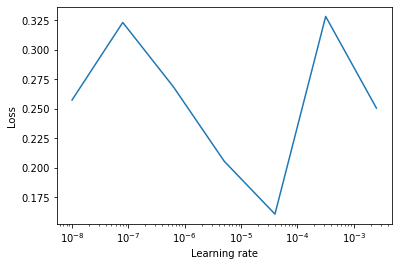

In [15]:
(lrs, losses) = find_lr(transfer_model, torch.nn.CrossEntropyLoss(),optimizer, train_data_loader,device=device)
plt.plot(lrs, losses)

plt.xscale("log")
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.show()

In [16]:
pytorch_total_params = sum(p.numel() for p in transfer_model.parameters())

## Differential Learning Rates

In [17]:
found_lr = 3e-4
optimizer = optim.Adam([
{ 'params': transfer_model.layer4.parameters(), 'lr': found_lr /3},
{ 'params': transfer_model.layer3.parameters(), 'lr': found_lr /9},
], lr=found_lr)

In [18]:
unfreeze_layers = [transfer_model.layer3, transfer_model.layer4]
for layer in unfreeze_layers:
    for param in layer.parameters():
        param.requires_grad = True

In [19]:
train(transfer_model, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader,val_data_loader, epochs=8, device=device)

GPU Memory:    1675MiB / 16280MiB Utilization:     8%  
Epoch: 0, Training Loss: 0.00, Validation Loss: 0.00, accuracy = 0.90, time: 9.671537637710571
GPU Memory:    1675MiB / 16280MiB Utilization:     9%  
Epoch: 1, Training Loss: 0.00, Validation Loss: 0.01, accuracy = 0.84, time: 9.642489671707153
GPU Memory:    1675MiB / 16280MiB Utilization:     9%  
Epoch: 2, Training Loss: 0.00, Validation Loss: 0.00, accuracy = 0.93, time: 9.645704507827759
GPU Memory:    1675MiB / 16280MiB Utilization:     9%  
Epoch: 3, Training Loss: 0.00, Validation Loss: 0.00, accuracy = 0.89, time: 9.672334909439087
GPU Memory:    1675MiB / 16280MiB Utilization:     9%  
Epoch: 4, Training Loss: 0.00, Validation Loss: 0.01, accuracy = 0.87, time: 9.743113279342651
GPU Memory:    1675MiB / 16280MiB Utilization:     9%  
Epoch: 5, Training Loss: 0.00, Validation Loss: 0.01, accuracy = 0.83, time: 9.652405023574829
GPU Memory:    1675MiB / 16280MiB Utilization:     9%  
Epoch: 6, Training Loss: 0.00, Validat